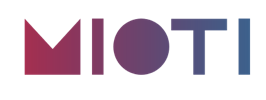
<center style="color:#888">Módulo Data Science in IoT<br/>Asignatura Machine Learning</center>

# Challenge S6: Reconocimiento facial

## Objetivos

El objetivo de este challenge es evaluar distintos clasificadores sobre un dataset de reconocimiento facial.

## Configuración del entorno

In [1]:
%matplotlib inline

from pylab import *
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

In [2]:
def dibuja_dataset(X, y):  
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

In [3]:
def plot_2d_separator(classifier, X, y, fill=False, ax=None, eps=None):
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    
    if eps is None:
        eps = X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]

    if ax is None:
        ax = plt.gca()

    ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels, colors="black")

También vamos a cargar algunas funciones que nos resultarán interesantes.

In [4]:
def print_faces(images, target, top_n):
    '''Dibuja las imágenes de las caras'''
    
    # set up the figure size in inches
    fig = plt.figure(figsize=(12, 12))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(top_n):
        # plot the images in a matrix of 20x20
        p = fig.add_subplot(20, 20, i + 1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)
        
        # label the image with the target value
        #p.text(0, 14, str(target[i]), color="red")
        p.text(1, 60, str(i), color="black", size=15)
        p.text(0, 60, str(i), color="yellow", size=15)

## Dataset

Esta vez utilizaremos un dataset de caras para realizar un algoritmo de reconocimiento facial.

In [5]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces()

In [6]:
faces.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [7]:
print(faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

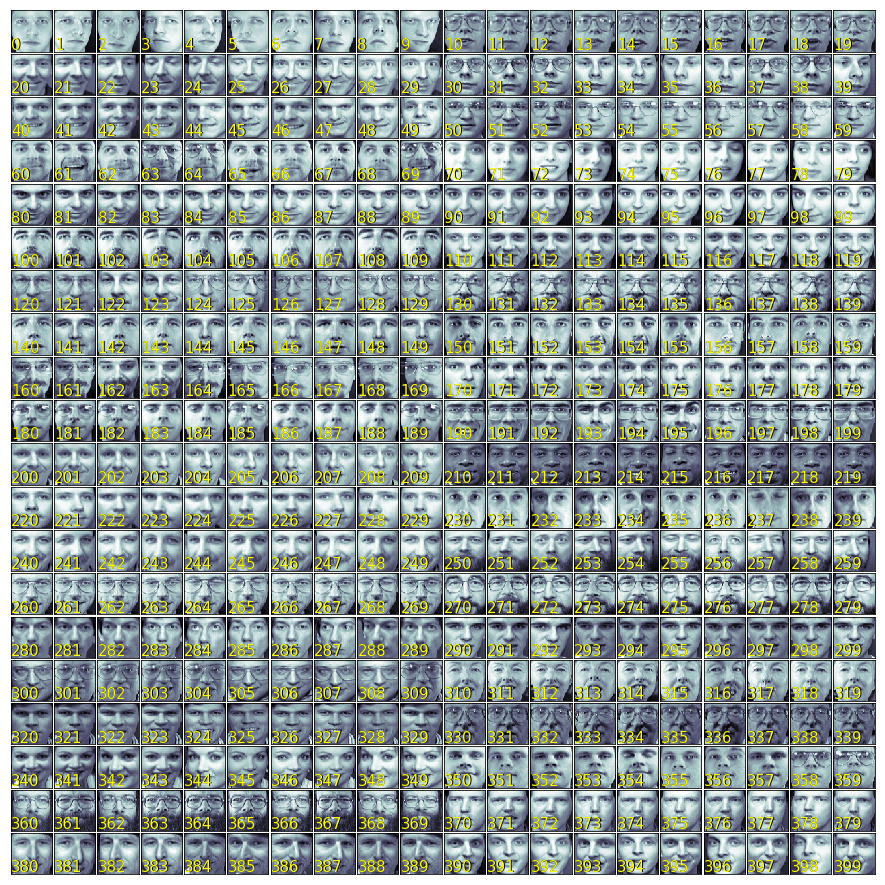

In [8]:
print_faces(faces.images, faces.target, 400)

### Atributos disponibles (X)

Asignamos la variable data a la variable X

In [9]:
dataset_X = faces.data

In [10]:
dataset_X *= 255

In [11]:
dataset_X.shape

(400, 4096)

In [12]:
dataset_X[0]

array([ 79.02893 ,  93.78099 , 106.42561 , ...,  38.987602,  41.095043,
        40.041325], dtype=float32)

### Variable objetivo (y)

En este caso, estamos ante un problema de clasificación, la variable a predecir es la persona a la que pertenece cada fotografía de un conjunto de 40 personas.

In [13]:
dataset_y = faces.target

In [14]:
dataset_y.shape

(400,)

In [15]:
print(dataset_y)

[ 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  2  2  2  2
  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7
  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8  8  9  9  9  9  9  9
  9  9  9  9 10 10 10 10 10 10 10 10 10 10 11 11 11 11 11 11 11 11 11 11
 12 12 12 12 12 12 12 12 12 12 13 13 13 13 13 13 13 13 13 13 14 14 14 14
 14 14 14 14 14 14 15 15 15 15 15 15 15 15 15 15 16 16 16 16 16 16 16 16
 16 16 17 17 17 17 17 17 17 17 17 17 18 18 18 18 18 18 18 18 18 18 19 19
 19 19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20 21 21 21 21 21 21
 21 21 21 21 22 22 22 22 22 22 22 22 22 22 23 23 23 23 23 23 23 23 23 23
 24 24 24 24 24 24 24 24 24 24 25 25 25 25 25 25 25 25 25 25 26 26 26 26
 26 26 26 26 26 26 27 27 27 27 27 27 27 27 27 27 28 28 28 28 28 28 28 28
 28 28 29 29 29 29 29 29 29 29 29 29 30 30 30 30 30 30 30 30 30 30 31 31
 31 31 31 31 31 31 31 31 32 32 32 32 32 32 32 32 32

Vamos a simplificar el problema y convertirlo en detectar gente con gafas y gente sin gafas. Como el tamaño del dataset es pequeño (sólo 400 instancias) vamos a reducirlo.

Buscamos a mano la gente con gafas y reclasificamos el vector `y`.

In [16]:
glasses = [(10, 19), (30, 32), (37, 38), (50, 59), (63, 64),
           (69, 69), (120, 121), (124, 129), (130, 139), (160, 161),
           (164, 169), (180, 182), (185, 185), (189, 189), (190, 192),
           (194, 194), (196, 199), (260, 269), (270, 279), (300, 309),
           (330, 339), (358, 359), (360, 369)]

In [17]:
transformed_dataset_y = np.zeros(len(dataset_y), dtype=np.int16) 
for g in glasses:
    for i in range(g[0], g[1] + 1):
        transformed_dataset_y[i] = 1
        
print(transformed_dataset_y)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0
 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
dataset_y = transformed_dataset_y

## Preprocesado de los datos

Examina los datos de entrenamiento y analiza si es necesario realizar algún preprocesamiento sobre los datos. Si es que sí aplicala.

* Variables que son enumerados
* Valores nulos
* Rango y escalado de los datos

In [19]:
type(dataset_X)

numpy.ndarray

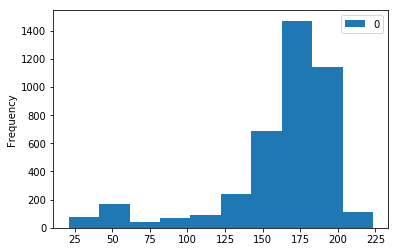

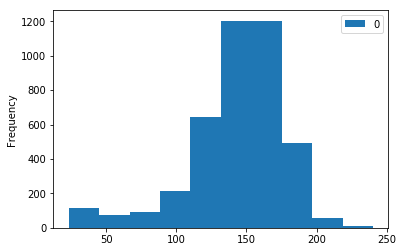

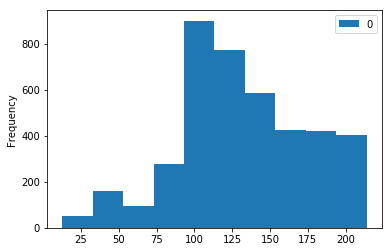

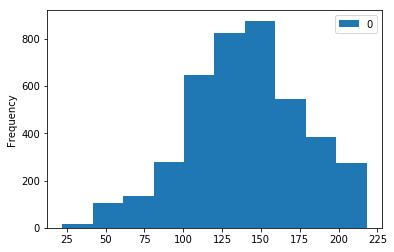

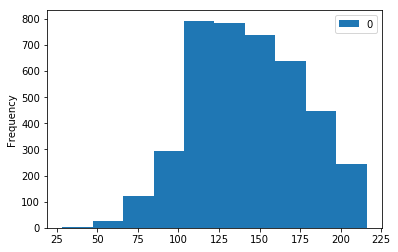

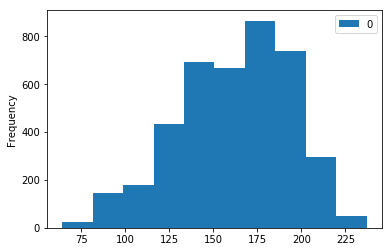

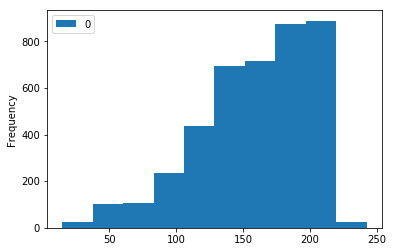

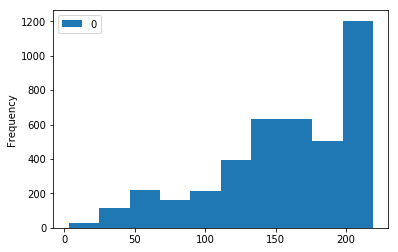

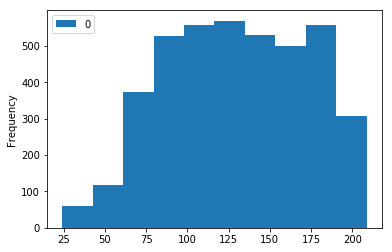

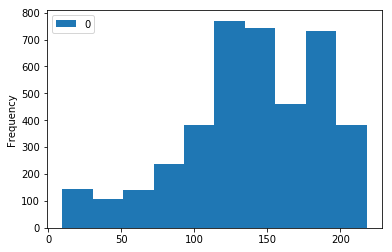

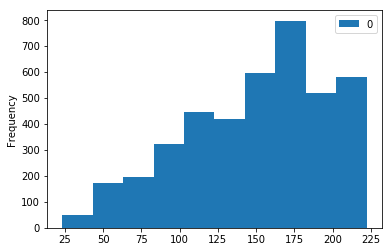

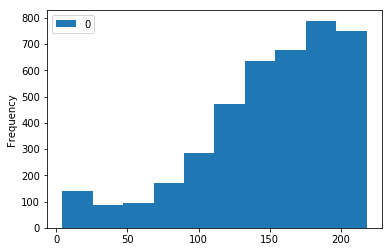

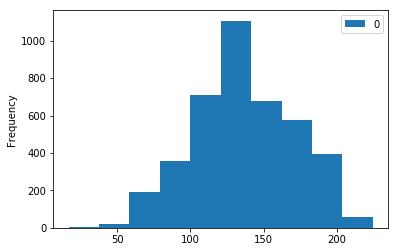

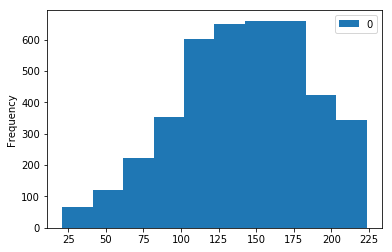

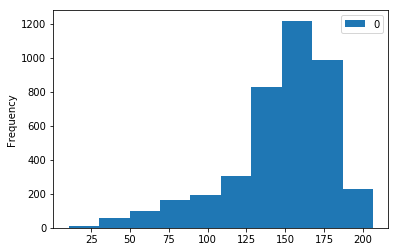

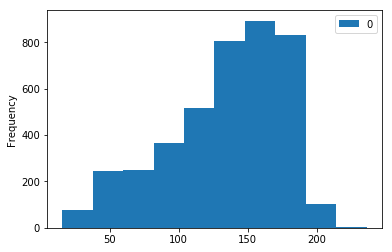

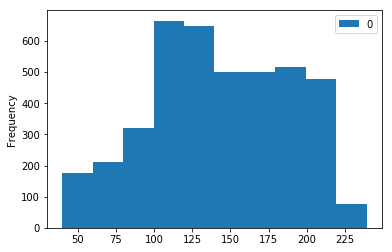

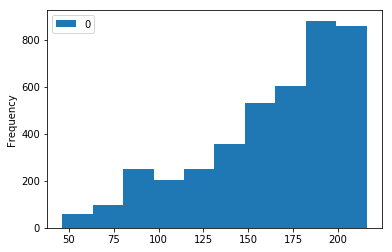

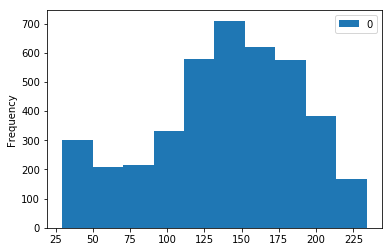

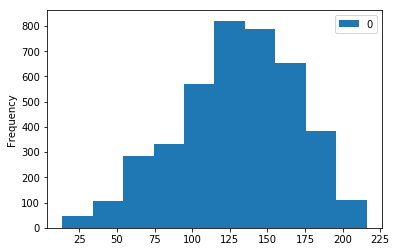

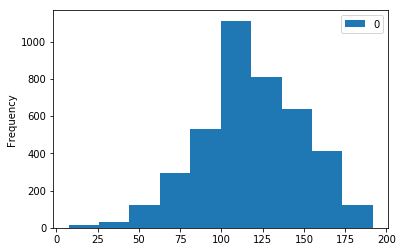

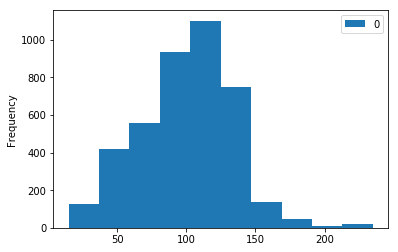

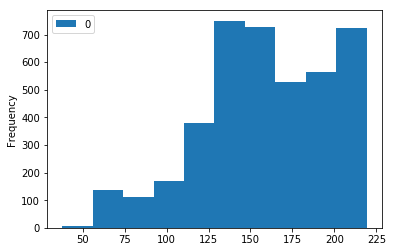

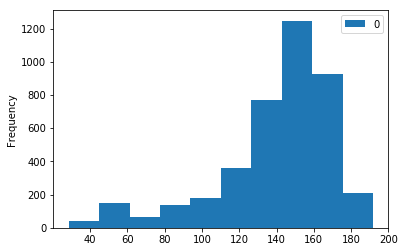

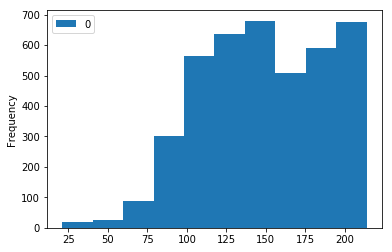

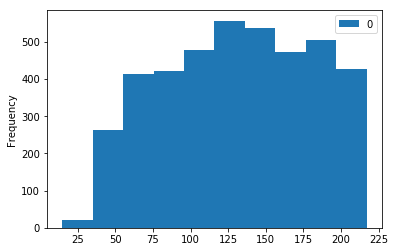

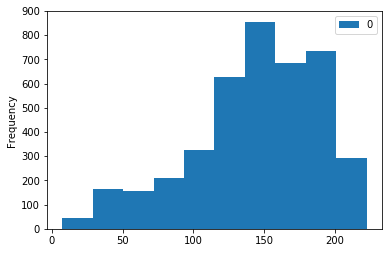

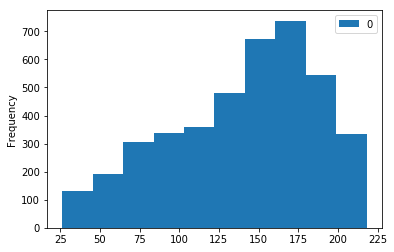

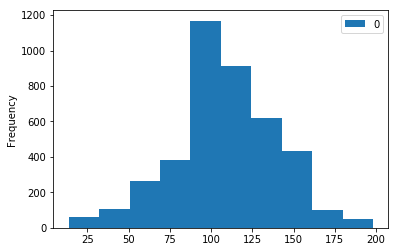

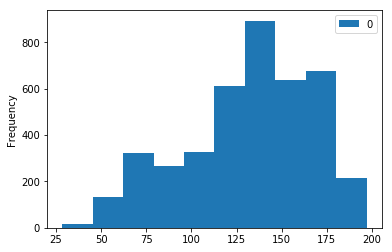

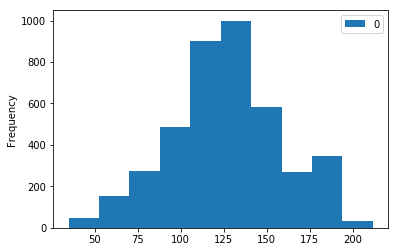

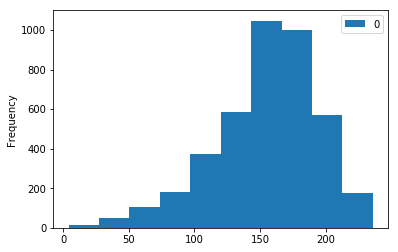

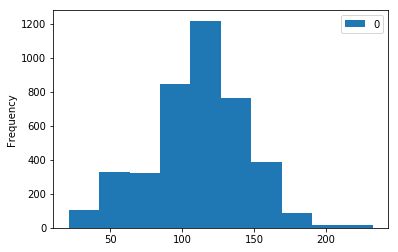

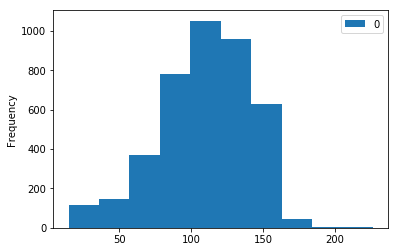

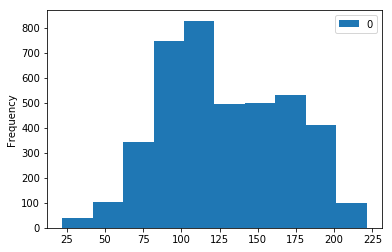

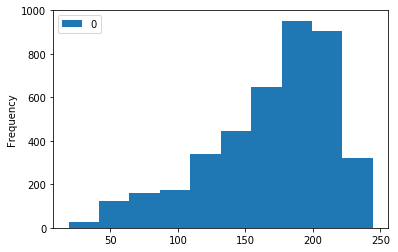

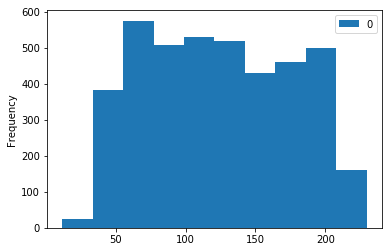

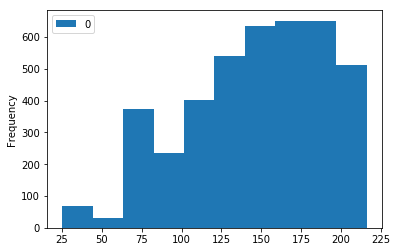

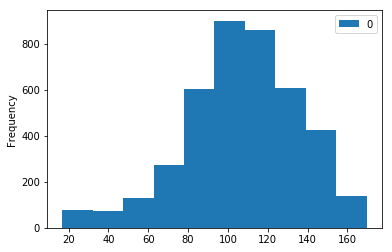

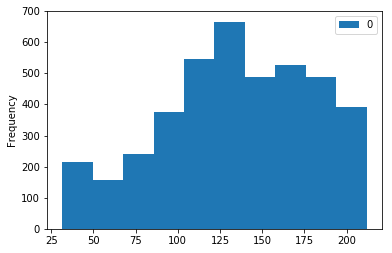

In [20]:
for i in range (0, 400, 10):
    pd.DataFrame(dataset_X[i]).plot.hist()

In [21]:
type(dataset_y)

numpy.ndarray

In [22]:
pd.DataFrame(dataset_X).isnull().values.any()

False

In [23]:
pd.DataFrame(dataset_y).isnull().values.any()

False

In [24]:
(pd.DataFrame(dataset_X).dtypes != float32).any()

False

### Dataset original y variable objetivo: gafas/no gafas

In [25]:
cross_val_score(SVC(), dataset_X, transformed_dataset_y, scoring='roc_auc', cv=5)

array([0.5, 0.5, 0.5, 0.5, 0.5])

### Dataset escalado y variable objetivo: gafas/no gafas

In [26]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler((-1, 1))
scaler.fit(dataset_X)
scaled_X = scaler.transform(dataset_X)

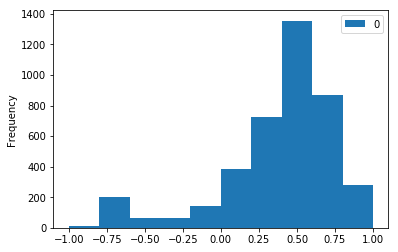

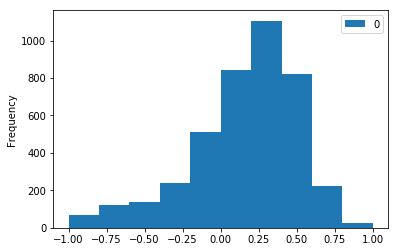

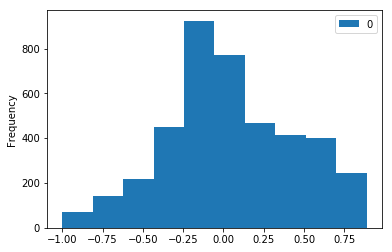

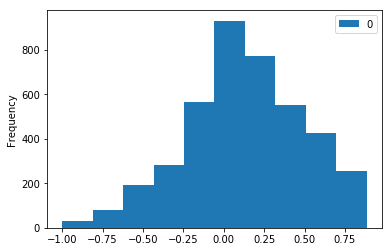

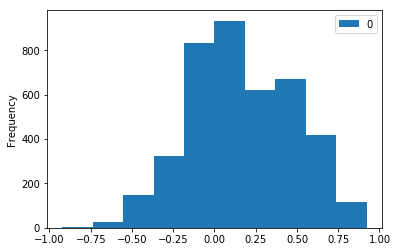

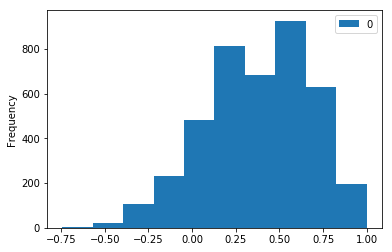

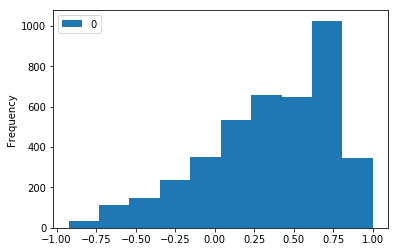

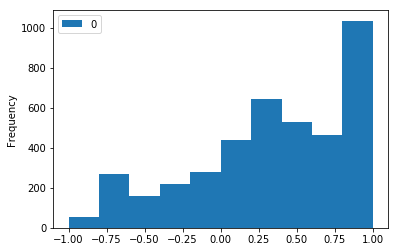

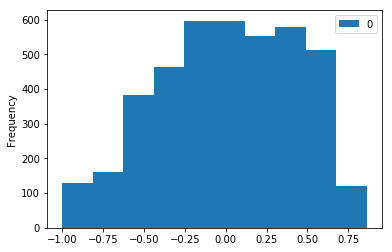

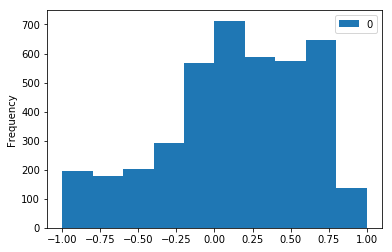

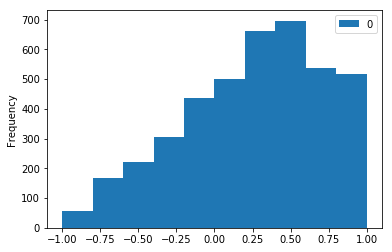

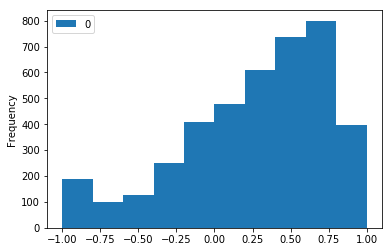

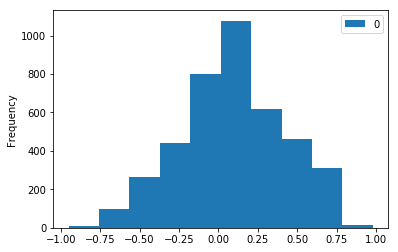

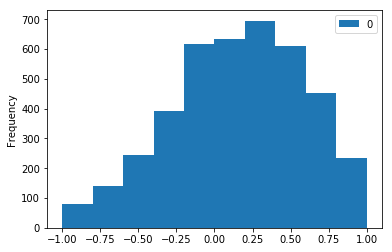

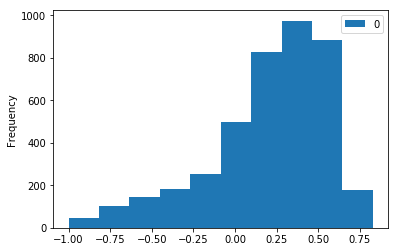

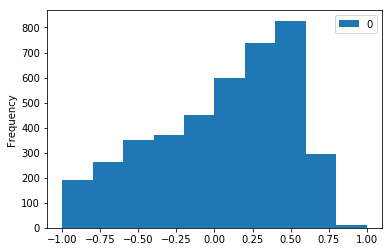

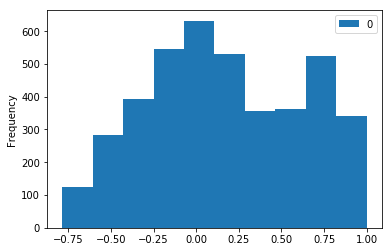

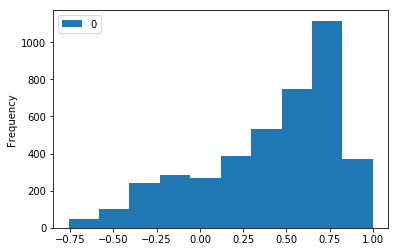

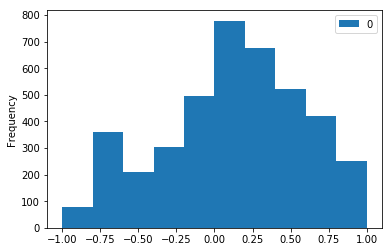

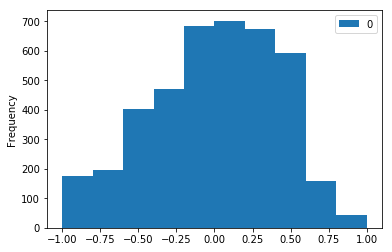

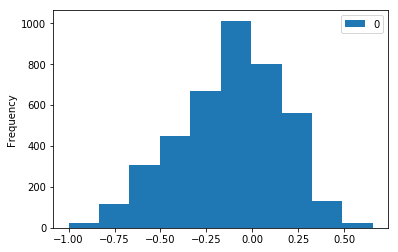

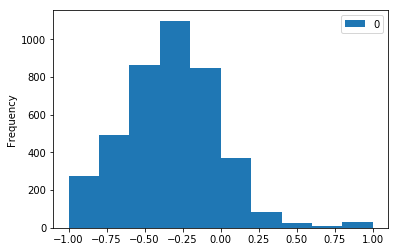

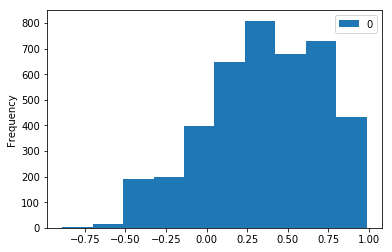

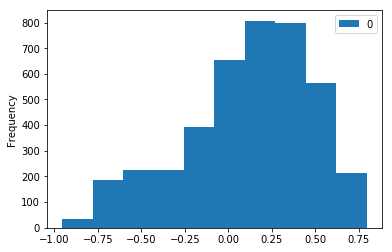

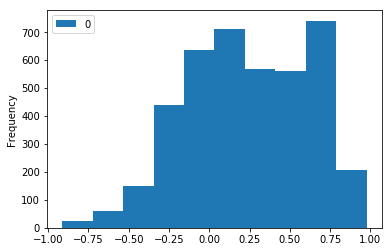

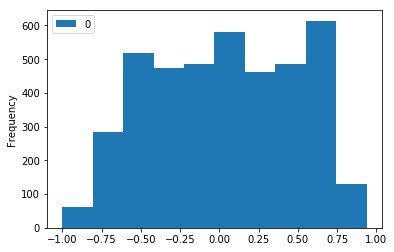

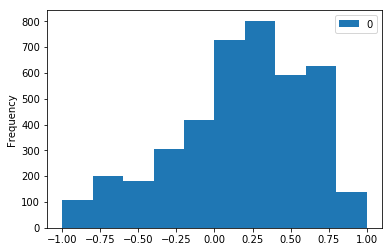

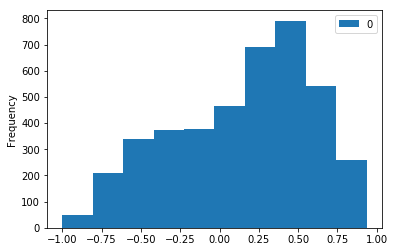

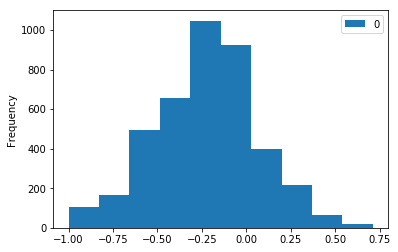

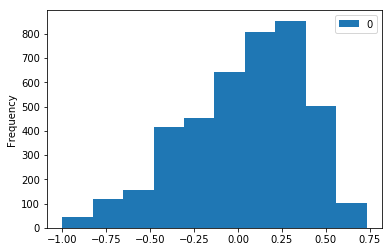

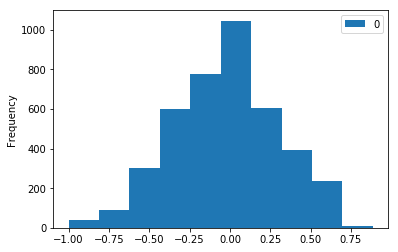

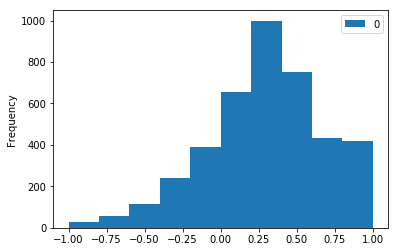

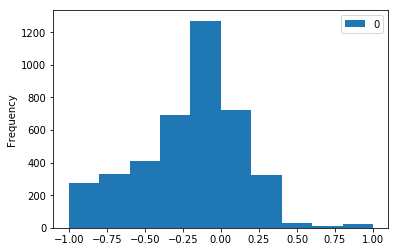

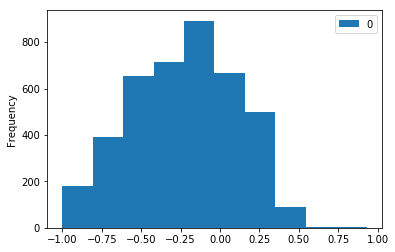

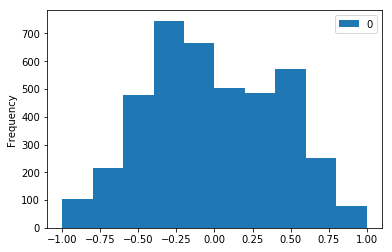

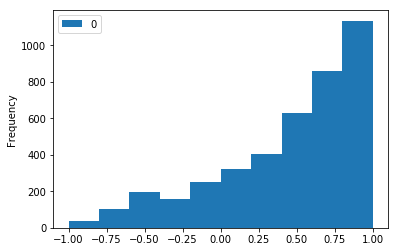

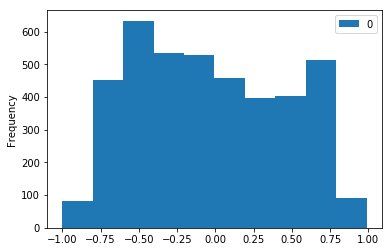

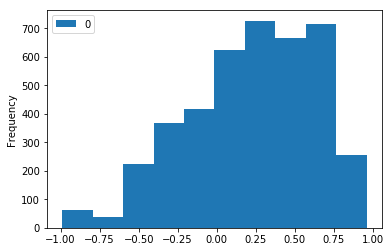

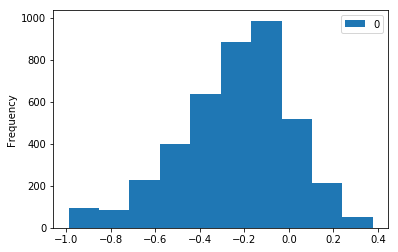

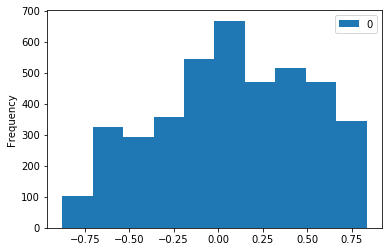

In [27]:
for i in range(0,400,10):
    pd.DataFrame(scaled_X[i]).plot.hist()

In [28]:
cross = cross_val_score(SVC(), scaled_X, transformed_dataset_y, scoring='roc_auc', cv=5)
cross

array([0.92178363, 0.91369048, 0.87872024, 0.96577381, 0.98369565])

In [29]:
cross.mean()

0.9327327603428863

In [30]:
cross_val_score(SVC(C = 1), scaled_X, transformed_dataset_y, scoring='roc_auc', cv=5)

array([0.92178363, 0.91369048, 0.87872024, 0.96577381, 0.98369565])

#### ¿Se te ocurre alguna manera de mejorar el rendimiento del algoritmo?. 

Puedes probar a evaluar a modificar el parámetro C y ver como se modifican los resultados.

In [31]:
out_ant = 0
for c in range (1, 51):
    out = cross_val_score(SVC(C=c), scaled_X, transformed_dataset_y, scoring='roc_auc', cv=5)
    print("C={} Roc AUC={}" .format(c, out.mean()))
    if out.mean() > out_ant:
        better_c = c
        out_ant = out.mean()

C=1 Roc AUC=0.9327327603428863
C=2 Roc AUC=0.950283884530166
C=3 Roc AUC=0.9548799535069558
C=4 Roc AUC=0.9582920162725654
C=5 Roc AUC=0.9628985280229558
C=6 Roc AUC=0.9683731520831064
C=7 Roc AUC=0.9710477507173731
C=8 Roc AUC=0.9726625213395808
C=9 Roc AUC=0.9729523083069994
C=10 Roc AUC=0.9725058797355709
C=11 Roc AUC=0.9725058797355708
C=12 Roc AUC=0.9719132523337329
C=13 Roc AUC=0.9711718154080854
C=14 Roc AUC=0.9711653454287894
C=15 Roc AUC=0.9710191465983801
C=16 Roc AUC=0.9708638670952745
C=17 Roc AUC=0.9710191465983801
C=18 Roc AUC=0.9713115442591989
C=19 Roc AUC=0.9711653454287894
C=20 Roc AUC=0.9710191465983801
C=21 Roc AUC=0.9710191465983801
C=22 Roc AUC=0.9710191465983801
C=23 Roc AUC=0.9710191465983801
C=24 Roc AUC=0.9710191465983801
C=25 Roc AUC=0.9710191465983801
C=26 Roc AUC=0.9710191465983801
C=27 Roc AUC=0.9710191465983801
C=28 Roc AUC=0.9710191465983801
C=29 Roc AUC=0.9710191465983801
C=30 Roc AUC=0.9710191465983801
C=31 Roc AUC=0.9710191465983801
C=32 Roc AUC=0.971

In [32]:
out_ant = 0
for c in range (1, 51):
    out = cross_val_score(SVC(C=c), dataset_X, transformed_dataset_y, scoring='roc_auc', cv=5)
    print("C={} Roc AUC={}" .format(c, out.mean()))
    if out.mean() > out_ant:
        better_c_noscaled = c
        out_ant = out.mean()

C=1 Roc AUC=0.5
C=2 Roc AUC=0.5
C=3 Roc AUC=0.5
C=4 Roc AUC=0.5
C=5 Roc AUC=0.5
C=6 Roc AUC=0.5
C=7 Roc AUC=0.5
C=8 Roc AUC=0.5
C=9 Roc AUC=0.5
C=10 Roc AUC=0.5
C=11 Roc AUC=0.5
C=12 Roc AUC=0.5
C=13 Roc AUC=0.5
C=14 Roc AUC=0.5
C=15 Roc AUC=0.5
C=16 Roc AUC=0.5
C=17 Roc AUC=0.5
C=18 Roc AUC=0.5
C=19 Roc AUC=0.5
C=20 Roc AUC=0.5
C=21 Roc AUC=0.5
C=22 Roc AUC=0.5
C=23 Roc AUC=0.5
C=24 Roc AUC=0.5
C=25 Roc AUC=0.5
C=26 Roc AUC=0.5
C=27 Roc AUC=0.5
C=28 Roc AUC=0.5
C=29 Roc AUC=0.5
C=30 Roc AUC=0.5
C=31 Roc AUC=0.5
C=32 Roc AUC=0.5
C=33 Roc AUC=0.5
C=34 Roc AUC=0.5
C=35 Roc AUC=0.5
C=36 Roc AUC=0.5
C=37 Roc AUC=0.5
C=38 Roc AUC=0.5
C=39 Roc AUC=0.5
C=40 Roc AUC=0.5
C=41 Roc AUC=0.5
C=42 Roc AUC=0.5
C=43 Roc AUC=0.5
C=44 Roc AUC=0.5
C=45 Roc AUC=0.5
C=46 Roc AUC=0.5
C=47 Roc AUC=0.5
C=48 Roc AUC=0.5
C=49 Roc AUC=0.5
C=50 Roc AUC=0.5


### Dataset escalado y variable original: personas

In [33]:
#se coge el C que mejor funciona y se hace el cross validation otra vez
cross_betterC = cross_val_score(SVC(C = better_c), scaled_X, transformed_dataset_y, scoring='roc_auc', cv=5)
cross_betterC

array([0.97733918, 0.96279762, 0.94047619, 0.98958333, 0.99456522])

In [34]:
cross_betterC.mean()

0.9729523083069994

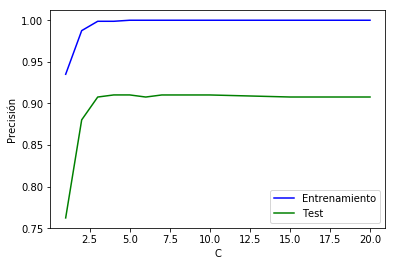

In [35]:
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC

C_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]

train_scores, test_scores = validation_curve(SVC(), scaled_X, transformed_dataset_y, param_name='C', param_range=C_values)
plt.plot(C_values, train_scores.mean(axis=1), 'b', label="Entrenamiento")
plt.plot(C_values, test_scores.mean(axis=1), 'g', label="Test")
plt.ylabel('Precisión')
plt.xlabel('C')
plt.legend(loc="best");

Se observa que obtenemos una precisión mayor en el conjunto de entrenamiento que en el de test. Lo cual tiene sentido ya que el modelo se ha entrenado con este dataset (el de entrenamiento), por lo que el algoritmo sabrá definir a qué clase pertenece. Sin embargo, el conjunto de test es un conjunto nuevo para el algoritmo y puede que tenga valores más difíciles de categorizar por lo que explica el por qué de la menor precisión.

También observamos que a partir de un cierto valor de C, los resultados no cambian. Esto se debe a que a partir de ciertas iteraciones el modelo ya ha llegado al máximo de su precisión para los conjuntos en estudio y a partir de ahí no puede mejorarla más.

## ¿Qué conclusiones obtienes?

Como podemos observar, al aplicar escalado mejoramos los resultados de la crossvalidación y de la curva ROC mientras que sin escalado no observamos lo mismo; no importa las veces que se ejecute la cross-validación ya que siempre nos dará lo mismo (y en nuestro caso este resultado será peor que con escalado.

Sin embargo, hay que tener en cuenta que el escalado para algunos algoritmos es importante, pero no para todos.